In [ ]:
! pip -q install equinox

In [ ]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sympy as sp
import equinox as eqx
from jax.nn import gelu
from scipy.special import roots_legendre

import itertools
import time
import optax

from jax.lax import scan
from jax import random, jit, vmap, grad

%config InlineBackend.figure_format='retina'

# PDE and the upper bound

Initial-boundary value problem

\begin{equation}
    \begin{split}
        &\frac{\partial u(x, t)}{\partial t} - \text{div}\,\text{grad}\,u(x, t) + a\cdot \text{grad}\,u(x, t) = f(x, t), \\
        &u(x, 0) = \phi(x),\\
        &\left.u(x, t)\right|_{x \in \partial \Gamma} = 0.
    \end{split}
\end{equation}

For the case $\text{div}\,a = 0$ the a poteriori error estimate can be written

\begin{equation}
    \int dx dt\,\text{grad}\, e(x, t) \cdot \text{grad}\, e(x, t) + \frac{1}{2} \int dx\,\left(e(x, T)\right)^2 \leq \int dx dt \,\left(y - \text{grad}\,v\right)\cdot \left(y - \text{grad}\,v\right) + C \int dxdt\,\left(f(x, t) - \frac{\partial v(x, t)}{\partial t} - a\cdot \text{grad}\,v(x, t) + \text{div} y(x, t)\right)^2,
\end{equation}

where $e(x, t) = u(x, t) - v(x, t)$ is the error, $v(x, t)$ approximate solution and $u(x, t)$ is the exact solution and $C = \frac{1}{\pi D_x}$, where $D_{x}$ is a number of spacial dimensions.

Source: https://arxiv.org/abs/1012.5089.

# Test cases

For $D_x = 1$

\begin{equation}
    \begin{split}
        &\frac{\partial u(x, t)}{\partial t} - \frac{\partial^2 u(x, t)}{\partial x^2} + a\frac{\partial u(x, t)}{\partial x} = f(x, t), \\
        &u(x, 0) = \phi(x),\\
        &u(0, t) = u(1, t) = 0.
    \end{split}
\end{equation}

We are going to use the following family of exact solutions

\begin{equation}
    u(x, t) = \text{Re} \left(\sum_{k=0}^{N} c_ke^{-(2\pi k)^2 t - 2\pi k a i t + 2 \pi k x i}\right) \sin(\pi x) = \widetilde{u}(x, t) \sin(\pi x).
\end{equation}

It is easy to see that

\begin{equation}
    \frac{\partial \widetilde{u}(x, t)}{\partial t} - \frac{\partial^2 \widetilde{u}(x, t)}{\partial x^2} + a\frac{\partial \widetilde{u}(x, t)}{\partial x} = 0,
\end{equation}

and that $u(x, t)$ fulfils boundary conditions. If we choose

\begin{equation}
    f(x, t) = \widetilde{u}(x, t)\left(\pi^2 \sin(\pi x) + a\pi \cos(\pi x)\right) - 2 \pi \frac{\partial \widetilde{u}(x, t)}{\partial x} \cos(\pi x),
\end{equation}

than $u(x, t)$ solves original equation.

In [ ]:
def trigonometric_series(x, N):
    # (N_x, N_coeff)
    return jnp.stack([jnp.exp(2*jnp.pi*1j*k*x) for k in range(N)], 1)

def d_trigonometric_series(x, N):
    # (N_x, N_coeff)
    return jnp.stack([2*jnp.pi*1j*k*jnp.exp(2*jnp.pi*1j*k*x) for k in range(N)], 1)

def d2_trigonometric_series(x, N):
    # (N_x, N_coeff)
    return jnp.stack([(2*jnp.pi*1j*k)**2*jnp.exp(2*jnp.pi*1j*k*x) for k in range(N)], 1)

def t_operator(t, N, a):
    # (N_coeff, N_t)
    K = jnp.arange(N)
    A = jnp.stack([jnp.exp(-t*(2*jnp.pi*k)**2 - 2*jnp.pi*a*1j*t) for k in K], 0)
    return A

def exact_solution(phi_0, a, x, t):
    N = phi_0.shape[0]
    A  = t_operator(t, N, a)
    C = trigonometric_series(x, N)
    return jnp.real(C @ (A * jnp.expand_dims(phi_0, 1))) * jnp.expand_dims(jnp.sin(jnp.pi*x), 1)

def d_exact_solution(phi_0, a, x, t):
    N = phi_0.shape[0]
    A  = t_operator(t, N, a)
    dC = d_trigonometric_series(x, N)
    C = trigonometric_series(x, N)
    r = jnp.real(dC @ (A * jnp.expand_dims(phi_0, 1))) * jnp.expand_dims(jnp.sin(jnp.pi*x), 1)
    r += jnp.pi * jnp.real(C @ (A * jnp.expand_dims(phi_0, 1))) * jnp.expand_dims(jnp.cos(jnp.pi*x), 1)
    return r

def compute_f(x, phi_0, C, dC, A):
    u_w = jnp.real(C @ (A * jnp.expand_dims(phi_0, 1)))
    d_u_w = jnp.real(dC @ (A * jnp.expand_dims(phi_0, 1)))
    f = u_w * (a * jnp.pi * jnp.expand_dims(jnp.cos(jnp.pi*x), 1) + jnp.pi**2 * jnp.expand_dims(jnp.sin(jnp.pi*x), 1))
    f = f - 2 * jnp.pi * d_u_w * jnp.expand_dims(jnp.cos(jnp.pi*x), 1)
    return f

def get_coeff(key, N, k=2):
    c = random.normal(key, (N,), dtype=jnp.complex64) / (1 + (2*jnp.pi*jnp.arange(N) / 10)**2)**k
    return c

def get_data_1(key, N = 150):
    keys= random.split(key, 2)
    a = 0.05*random.normal(keys[0])
    phi_0 = get_coeff(keys[1], N,)
    return phi_0, a

In [ ]:
key = random.PRNGKey(34)

N = 150
phi_0, a = get_data_1(key, N)
x = jnp.linspace(0, 1, 100)
t = jnp.linspace(0, 0.1, 125)

sol = exact_solution(phi_0, a, x, t)
coords = jnp.stack(jnp.meshgrid(x, t, indexing="ij"), 2)

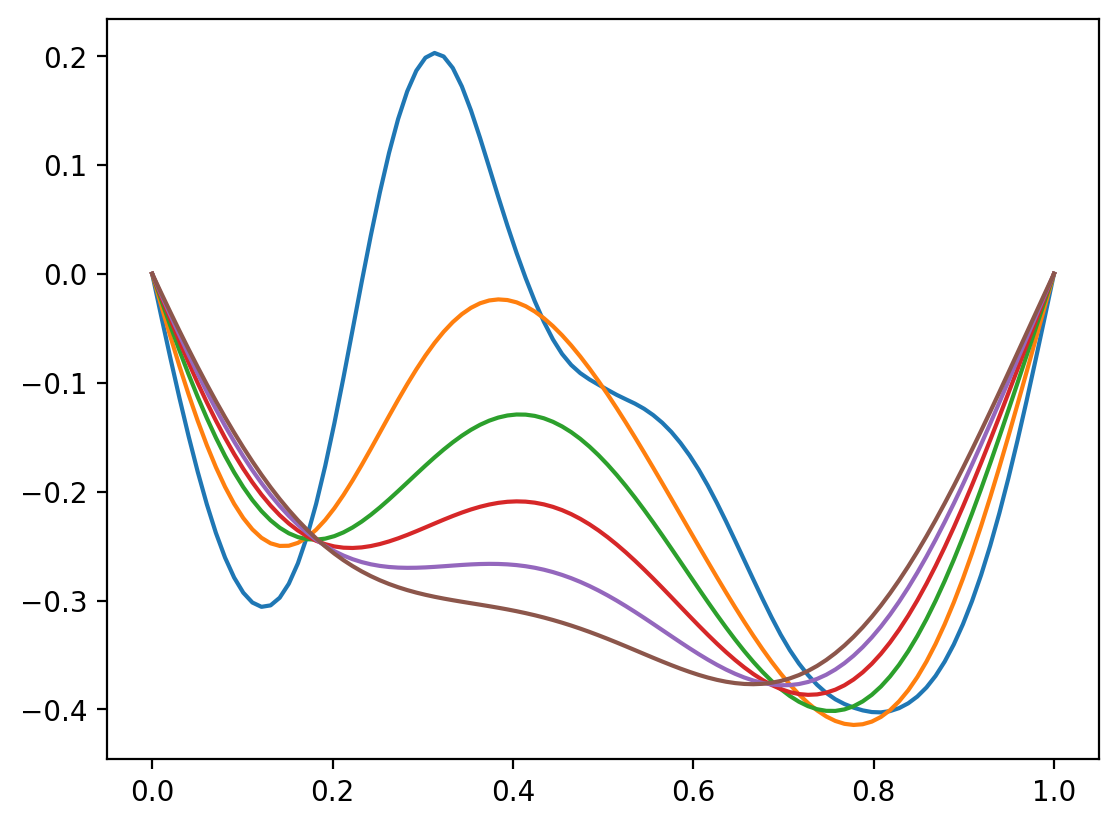

In [ ]:
for i in [0, 10, 20, 30, 40, 50]:
    plt.plot(x, sol[:, i])

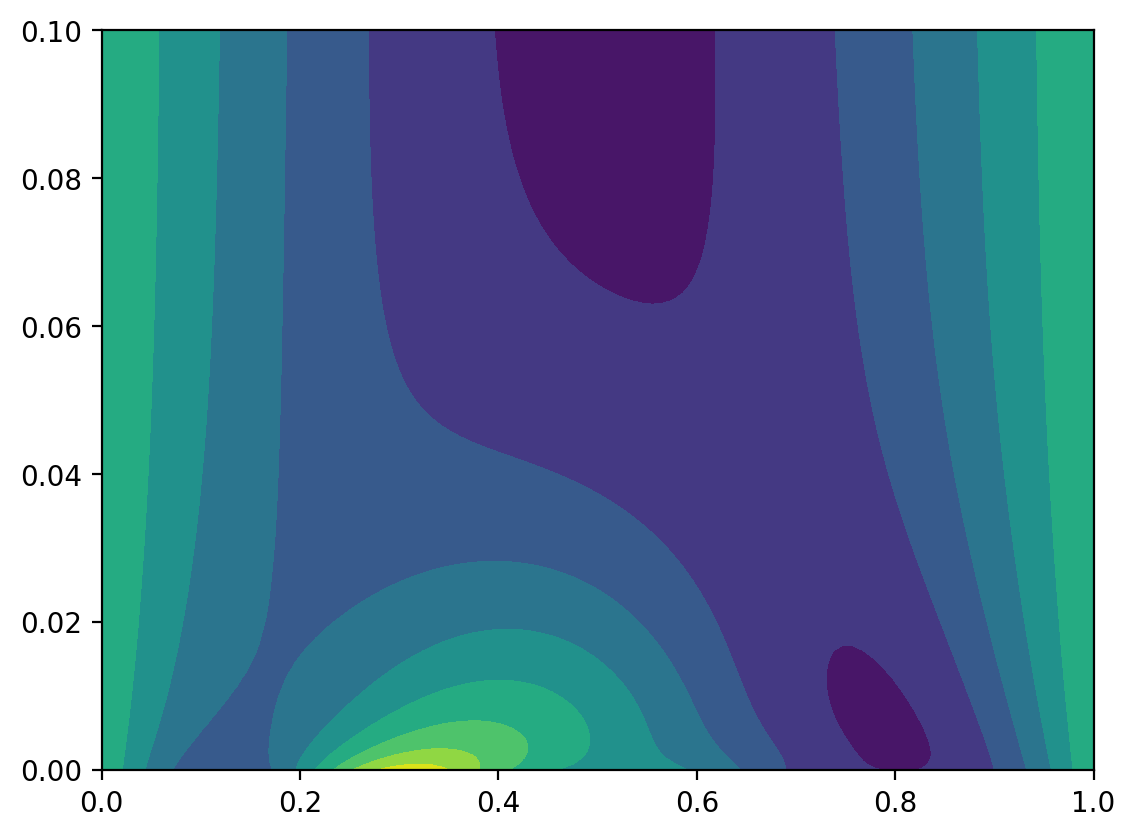

In [ ]:
plt.contourf(coords[:, :, 0], coords[:, :, 1], sol)

In [ ]:
C = trigonometric_series(x, N)
dC = d_trigonometric_series(x, N)
A = t_operator(t, N, a)
f = compute_f(x, phi_0, C, dC, A)

# Residual loss

In [ ]:
class PiNN(eqx.Module):
    matrices: list
    biases: list

    def __init__(self, N_features, N_layers, key):
        keys = random.split(key, N_layers+1)
        features = [N_features[0],] + [N_features[1],]*(N_layers-1) + [N_features[-1],]
        self.matrices = [random.normal(key, (f_in, f_out)) / jnp.sqrt((f_in + f_out)/2) for f_in, f_out, key in zip(features[:-1], features[1:], keys)]
        keys = random.split(keys[-1], N_layers)
        self.biases = [random.normal(key, (f_out,)) for f_in, f_out, key in zip(features[:-1], features[1:], keys)]

    def __call__(self, x, B, ic):
        f = jnp.concatenate([jnp.cos(B @ x), jnp.sin(B @ x)], 0)
        f = f @ self.matrices[0] + self.biases[0]
        for i in range(1, len(self.matrices)):
            f = gelu(f)
            f = f @ self.matrices[i] + self.biases[i]
        return jnp.sin(jnp.pi*x[0]) * (x[1] * f[0] + ic(x[0]))

def compute_loss(model, coordinates, B, ic, f, a):
    du = vmap(lambda x: grad(model, argnums=0)(x, B, ic))(coordinates)
    d2u_dx2 = vmap(grad(lambda x: grad(model, argnums=0)(x, B, ic)[0]))(coordinates)
    l = du[:, 1] + a*du[:, 0] - d2u_dx2[:, 0] - f
    return jnp.linalg.norm(l)

def compute_error_energy_norm(model, coordinates, weights, B, ic, d_exact_sol, exact_sol, delta_t, delta_x):
    du = vmap(lambda x: grad(model, argnums=0)(x, B, ic))(coordinates)
    integrand = (du[:, 0] - d_exact_sol)**2
    l = jnp.sum(jnp.sum(integrand.reshape(weights.size, weights.size)*weights, axis=1) * weights[0])*delta_t*delta_x
    u_T = vmap(lambda x: model(x, B, ic))(coordinates.reshape(weights.size, weights.size, 2)[:, -1, :].reshape(-1, 2))
    l += jnp.sum(weights[0]*(u_T - exact_sol.reshape(weights.size, weights.size)[:, -1])**2)*delta_x / 2
    return l

compute_loss_and_grads = eqx.filter_value_and_grad(compute_loss)

@eqx.filter_jit
def make_step(model, coordinates, B, ic, f, a, optim, opt_state):
    loss, grads = compute_loss_and_grads(model, coordinates, B, ic, f, a)
    updates, opt_state = optim.update(grads, opt_state, eqx.filter(model, eqx.is_array))
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [ ]:
key = random.PRNGKey(166)

N = 150
phi_0, a = get_data_1(key, N)

ic = lambda x: jnp.real(jnp.exp(2*jnp.pi*1j*jnp.arange(N)*x) @ phi_0)

N_epochs = 10000
M = 64
N_x = N_t = 64
x = jnp.linspace(0, 1, N_x+2)[1:-1]
t = jnp.linspace(0, 0.1, N_t+1)[1:]
ind = jnp.arange(N_x*N_t)
coordinates = jnp.stack(jnp.meshgrid(x, t, indexing="ij"), 2).reshape(-1, 2)

sol = exact_solution(phi_0, a, x, t)
sol = sol.reshape(-1,)

roots, weights_ = roots_legendre(N_x)
x_ = jnp.array((roots + 1) / 2)
t_ = jnp.array((roots + 1) / 2) * 0.1
delta_t = 0.1 / 2
delta_x = 1 / 2
weights_ = jnp.array(weights_).reshape(1, -1)
coordinates_ = jnp.stack(jnp.meshgrid(x_, t_, indexing="ij"), 2).reshape(-1, 2)
sol_ = exact_solution(phi_0, a, x_, t_)
d_sol_ = d_exact_solution(phi_0, a, x_, t_)
sol_ = sol_.reshape(-1,)
d_sol_ = d_sol_.reshape(-1,)

C = trigonometric_series(x, N)
dC = d_trigonometric_series(x, N)
A = t_operator(t, N, a)
f = compute_f(x, phi_0, C, dC, A)
f = f.reshape(-1,)

N_fourier_features = 25
key = random.PRNGKey(23)
B = random.normal(key, (N_fourier_features, 2))*10

N_features = [2*N_fourier_features, 50, 1]
N_layers = 4
key = random.PRNGKey(14)
model = PiNN(N_features, N_layers, key)

learning_rate = 1e-4
N_drop = 3000
gamma = 0.5
sc = optax.exponential_decay(learning_rate, N_drop, gamma)
optim = optax.lion(learning_rate=sc)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

carry = [model, opt_state, sol, coordinates, B, f, a, ind, d_sol_, sol_, delta_t, delta_x]
keys = random.split(key, N_epochs)

In [ ]:
def make_step_scan(carry, key):
    model, opt_state, exact_solution, coords, B, f, a, ind, d_sol_, sol_, delta_t, delta_x = carry
    n = random.choice(key, ind, shape = (M,))
    loss, model, opt_state = make_step(model, coords[n], B, ic, f[n], a, optim, opt_state)
    approximate_solution = vmap(model, in_axes=(0, None, None))(coords, B, ic)
    error = jnp.linalg.norm(exact_solution - approximate_solution) / jnp.linalg.norm(exact_solution)
    energy_error = jnp.sqrt(compute_error_energy_norm(model, coordinates_, weights_, B, ic, d_sol_, sol_, delta_t, delta_x))
    return [model, opt_state, exact_solution, coords, B, f, a, ind, d_sol_, sol_, delta_t, delta_x], jnp.stack([loss, error, energy_error])

In [ ]:
start = time.time()
data, history = scan(make_step_scan, carry, keys)
model = data[0]
stop = time.time()
print((stop - start)/60)

0.21893995602925617


0.007843864


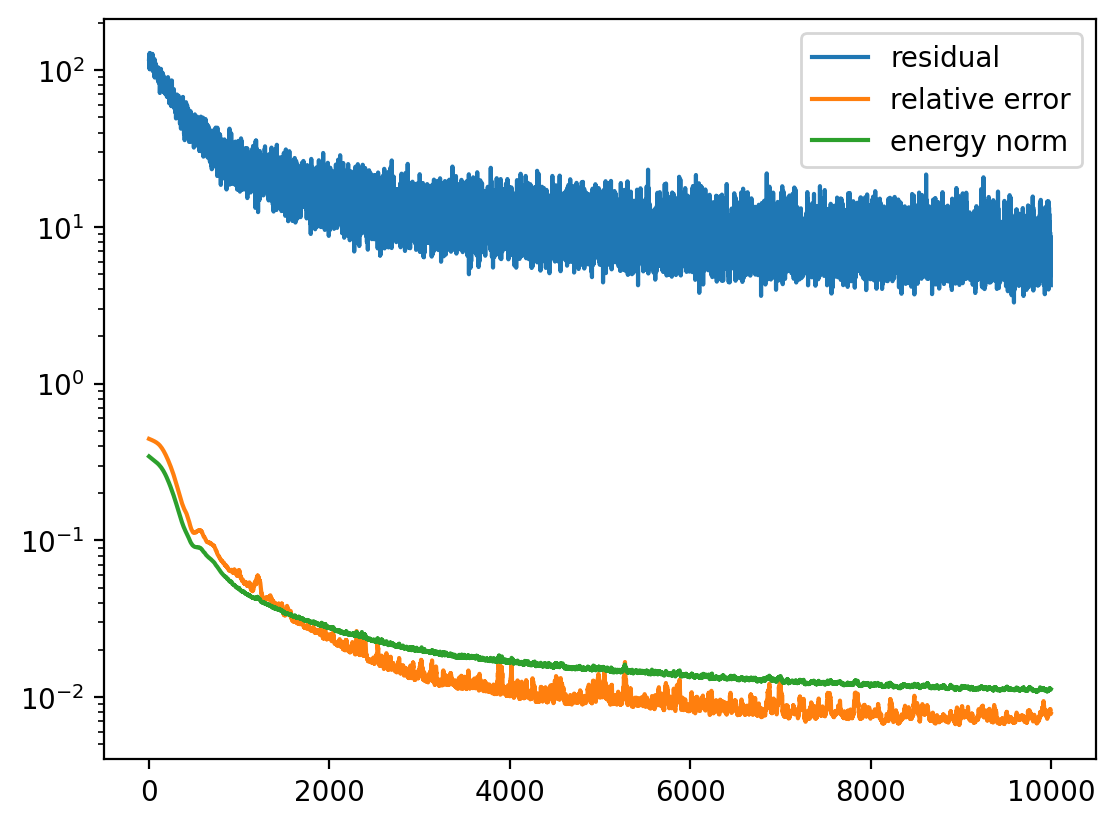

In [ ]:
plt.yscale("log")
plt.plot(history[:, 0], label="residual")
plt.plot(history[:, 1], label="relative error")
plt.plot(history[:, 2], label="energy norm")
print(history[-1, 1])
plt.legend();

In [ ]:
approximate_solution = vmap(model, in_axes=(0, None, None))(coordinates, B, ic)
a_s = approximate_solution.reshape(N_x, N_t)

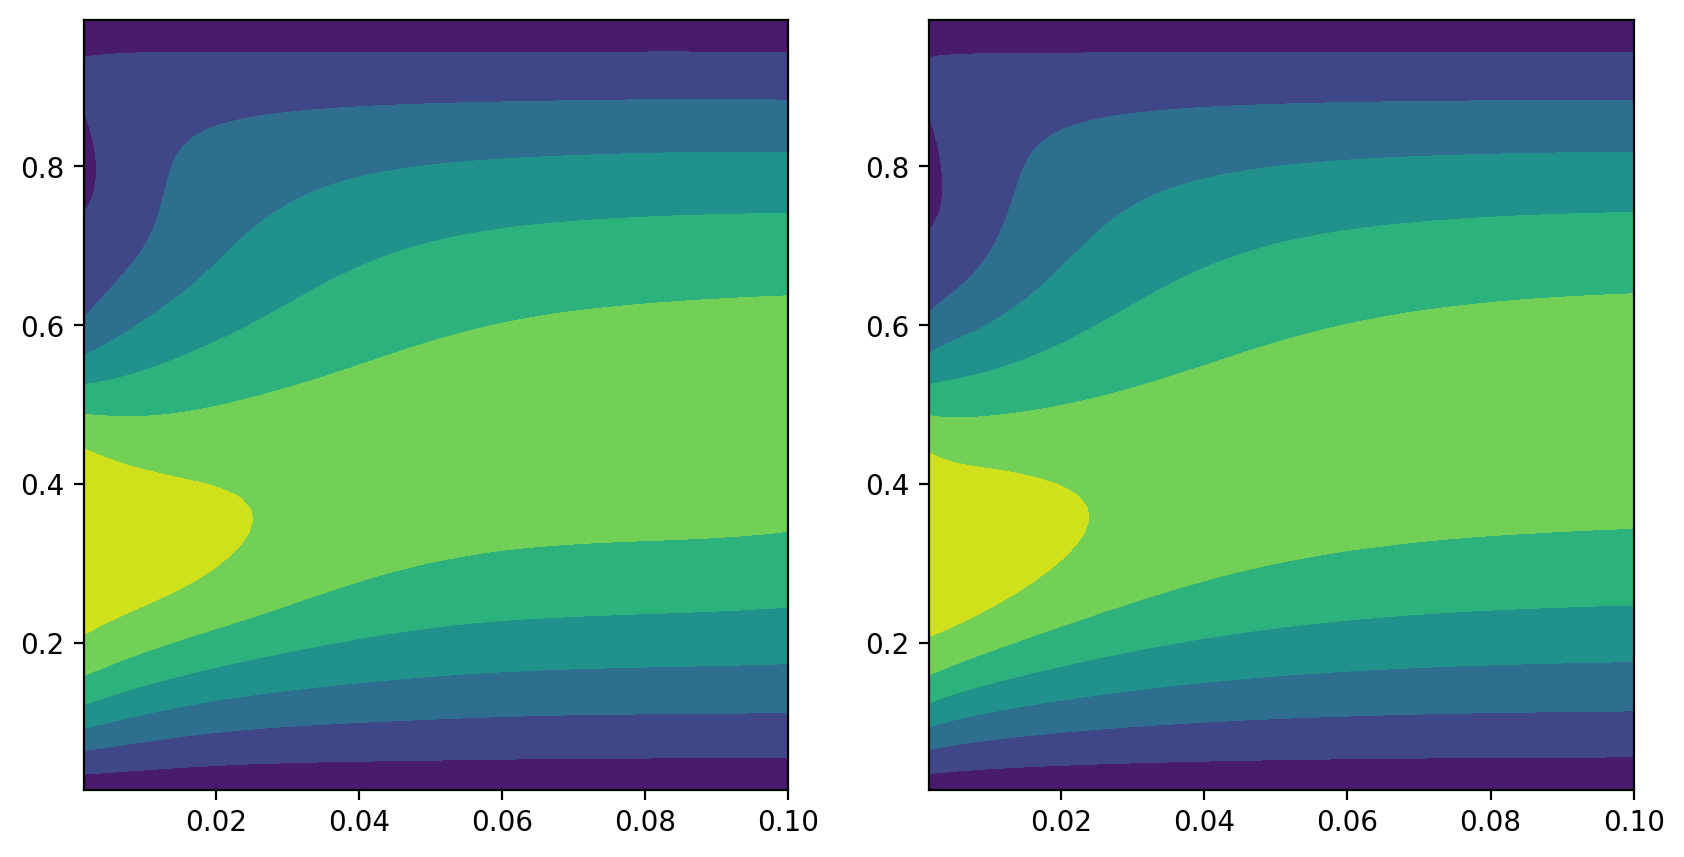

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].contourf(t, x, a_s)
ax[1].contourf(t, x, sol.reshape(N_x, N_t));

# Astral loss

In [ ]:
class PiNNu(eqx.Module):
    matrices: list
    biases: list

    def __init__(self, N_features, N_layers, key):
        keys = random.split(key, N_layers+1)
        features = [N_features[0],] + [N_features[1],]*(N_layers-1) + [N_features[-1],]
        self.matrices = [random.normal(key, (f_in, f_out)) / jnp.sqrt((f_in + f_out)/2) for f_in, f_out, key in zip(features[:-1], features[1:], keys)]
        keys = random.split(keys[-1], N_layers)
        self.biases = [random.normal(key, (f_out,)) for f_in, f_out, key in zip(features[:-1], features[1:], keys)]

    def __call__(self, x, B, ic):
        f = jnp.concatenate([jnp.cos(B @ x), jnp.sin(B @ x)], 0)
        f = f @ self.matrices[0] + self.biases[0]
        for i in range(1, len(self.matrices)):
            f = gelu(f)
            f = f @ self.matrices[i] + self.biases[i]
        return f[0]

class PiNN2(eqx.Module):
    models: list

    def __init__(self, N_features, N_layers, key):
        keys = random.split(key, 2)
        self.models = [PiNNu(N_features, N_layers, keys[0]),]
        self.models.append(PiNN(N_features, N_layers, keys[1]))

    def __call__(self, x, B, ic, i):
        return self.models[i](x, B, ic)

def compute_loss(model, coordinates, weights, B, ic, f, a, delta_t, delta_x):
    du = vmap(lambda x: grad(model, argnums=0)(x, B, ic, 1))(coordinates)
    dy_dx = vmap(lambda x: grad(model, argnums=0)(x, B, ic, 0))(coordinates)[:, 0]
    y = vmap(lambda x: model(x, B, ic, 0))(coordinates)
    r = f - du[:, 1] - a*du[:, 0] + dy_dx
    l = y - du[:, 0]
    ub = jnp.sum(jnp.sum((l**2).reshape(weights.size, weights.size)*weights, axis=1) * weights[0])*delta_t*delta_x
    ub += jnp.sum(jnp.sum((r**2).reshape(weights.size, weights.size)*weights, axis=1) * weights[0])*delta_t*delta_x / jnp.pi
    return ub

def compute_error_energy_norm(model, coordinates, weights, B, ic, d_exact_sol, exact_sol, delta_t, delta_x):
    du = vmap(lambda x: grad(model, argnums=0)(x, B, ic, 1))(coordinates)
    integrand = (du[:, 0] - d_exact_sol)**2
    l = jnp.sum(jnp.sum(integrand.reshape(weights.size, weights.size)*weights, axis=1) * weights[0])*delta_t*delta_x
    u_T = vmap(lambda x: model(x, B, ic, 1))(coordinates.reshape(weights.size, weights.size, 2)[:, -1, :].reshape(-1, 2))
    l += jnp.sum(weights[0]*(u_T - exact_sol.reshape(weights.size, weights.size)[:, -1])**2)*delta_x / 2
    return l

compute_loss_and_grads = eqx.filter_value_and_grad(compute_loss)

@eqx.filter_jit
def make_step(model, coordinates, weights, B, ic, f, a, delta_t, delta_x, optim, opt_state):
    loss, grads = compute_loss_and_grads(model, coordinates, weights, B, ic, f, a, delta_t, delta_x)
    updates, opt_state = optim.update(grads, opt_state, eqx.filter(model, eqx.is_array))
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [ ]:
key = random.PRNGKey(131)
key = random.split(key)[0]

N = 150
phi_0, a = get_data_1(key, N)

ic = lambda x: jnp.real(jnp.exp(2*jnp.pi*1j*jnp.arange(N)*x) @ phi_0)

N_epochs = 10000
M = 15*15
N_x = N_t = 64
x = jnp.linspace(0, 1, N_x)
t = jnp.linspace(0, 0.1, N_t)
ind = jnp.arange(N_x*N_t)
coordinates = jnp.stack(jnp.meshgrid(x, t, indexing="ij"), 2).reshape(-1, 2)

sol = exact_solution(phi_0, a, x, t)
sol = sol.reshape(-1,)

roots, weights_ = roots_legendre(N_x)
x_ = jnp.array((roots + 1) / 2)
t_ = jnp.array((roots + 1) / 2) * 0.1
delta_t = 0.1 / 2
delta_x = 1 / 2
weights_ = jnp.array(weights_).reshape(1, -1)
coordinates_ = jnp.stack(jnp.meshgrid(x_, t_, indexing="ij"), 2).reshape(-1, 2)
sol_ = exact_solution(phi_0, a, x_, t_)
d_sol_ = d_exact_solution(phi_0, a, x_, t_)
sol_ = sol_.reshape(-1,)
d_sol_ = d_sol_.reshape(-1,)

C = trigonometric_series(x, N)
dC = d_trigonometric_series(x, N)
A = t_operator(t, N, a)
f = compute_f(x, phi_0, C, dC, A)
f = f.reshape(-1,)

C_ = trigonometric_series(x_, N)
dC_ = d_trigonometric_series(x_, N)
A_ = t_operator(t_, N, a)
f_ = compute_f(x_, phi_0, C_, dC_, A_)
f_ = f_.reshape(-1,)

N_fourier_features = 25
key = random.PRNGKey(23)
B = random.normal(key, (N_fourier_features, 2))*10

N_features = [2*N_fourier_features, 50, 1]
N_layers = 4
key = random.PRNGKey(14)
model = PiNN2(N_features, N_layers, key)

learning_rate = 1e-4
N_drop = 3000
gamma = 0.5
sc = optax.exponential_decay(learning_rate, N_drop, gamma)
optim = optax.lion(learning_rate=sc)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

carry = [model, opt_state, sol, coordinates_, weights_, B, f_, a, ind, d_sol_, sol_, delta_t, delta_x, coordinates]
keys = random.split(key, N_epochs)

In [ ]:
def make_step_scan(carry, key):
    model, opt_state, exact_solution, coords, weights, B, f, a, ind, d_sol_, sol_, delta_t, delta_x, coordinates = carry

    loss, model, opt_state = make_step(model, coords, weights, B, ic, f, a, delta_t, delta_x, optim, opt_state)
    approximate_solution = vmap(model, in_axes=(0, None, None, None))(coordinates, B, ic, 1)
    error = jnp.linalg.norm(exact_solution - approximate_solution) / jnp.linalg.norm(exact_solution)
    energy_error = jnp.sqrt(compute_error_energy_norm(model, coords, weights, B, ic, d_sol_, sol_, delta_t, delta_x))
    return [model, opt_state, exact_solution, coords, weights, B, f, a, ind, d_sol_, sol_, delta_t, delta_x, coordinates], jnp.stack([loss, error, energy_error])

In [ ]:
start = time.time()
data, history = scan(make_step_scan, carry, keys)
model = data[0]
stop = time.time()
print((stop - start)/60)

0.4527855634689331


0.024894616


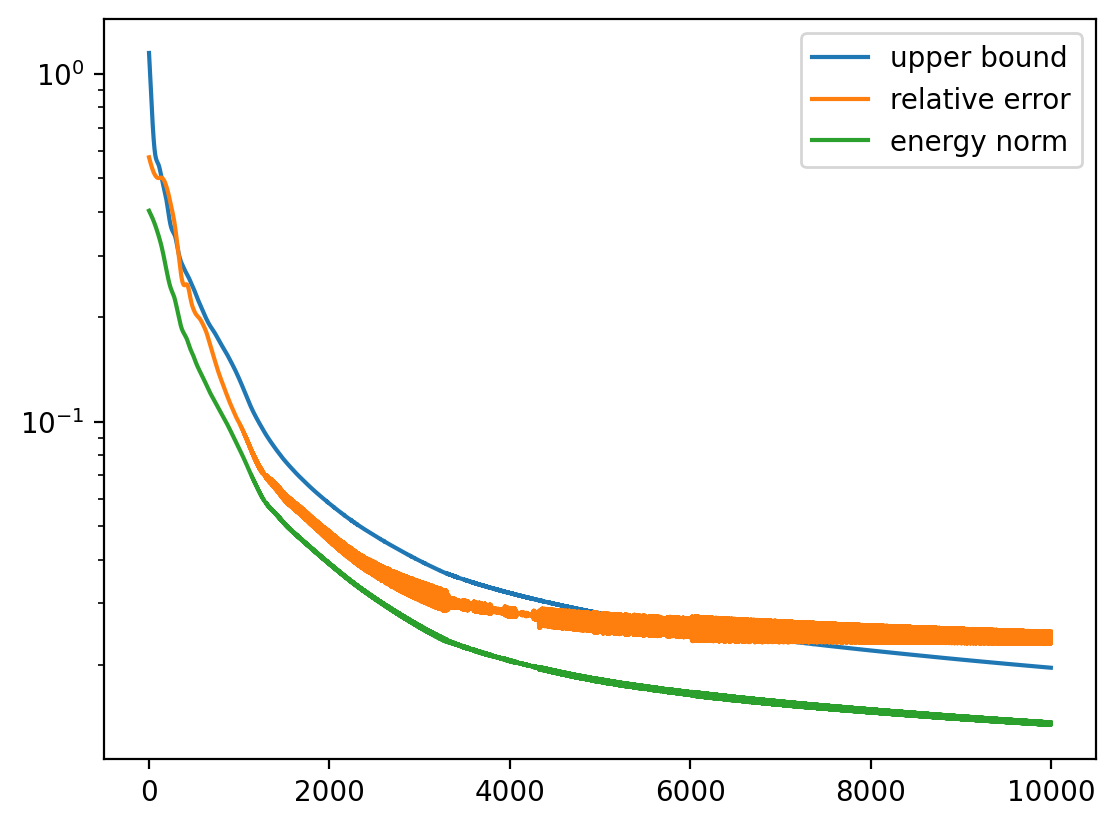

In [ ]:
plt.yscale("log")
plt.plot(jnp.sqrt(history[:, 0]), label="upper bound")
plt.plot(history[:, 1], label="relative error")
plt.plot(history[:, 2], label="energy norm")
print(history[-1, 1])
plt.legend();

In [ ]:
N_x_ = 200
roots, weights_ = roots_legendre(N_x_)
x_ = jnp.array((roots + 1) / 2)
t_ = jnp.array((roots + 1) / 2) * 0.1
delta_t = 0.1 / 2
delta_x = 1 / 2
weights_ = jnp.array(weights_).reshape(1, -1)
coordinates_ = jnp.stack(jnp.meshgrid(x_, t_, indexing="ij"), 2).reshape(-1, 2)
sol_ = exact_solution(phi_0, a, x_, t_)
d_sol_ = d_exact_solution(phi_0, a, x_, t_)
sol_ = sol_.reshape(-1,)
d_sol_ = d_sol_.reshape(-1,)

C = trigonometric_series(x, N)
dC = d_trigonometric_series(x, N)
A = t_operator(t, N, a)
f = compute_f(x, phi_0, C, dC, A)
f = f.reshape(-1,)

C_ = trigonometric_series(x_, N)
dC_ = d_trigonometric_series(x_, N)
A_ = t_operator(t_, N, a)
f_ = compute_f(x_, phi_0, C_, dC_, A_)
f_ = f_.reshape(-1,)

In [ ]:
# note that there is a fine-tuning to a given grid so loss and error should be recomputed with higher resolution
error = jnp.sqrt(compute_error_energy_norm(model, coordinates_, weights_, B, ic, d_sol_, sol_, delta_t, delta_x))
loss = jnp.sqrt(compute_loss(model, coordinates_, weights_, B, ic, f_, a, delta_t, delta_x))
print(error, loss)

0.013823082 0.01973004


In [ ]:
approximate_solution = vmap(model, in_axes=(0, None, None, None))(coordinates, B, ic, 1)
a_s = approximate_solution.reshape(N_x, N_x)

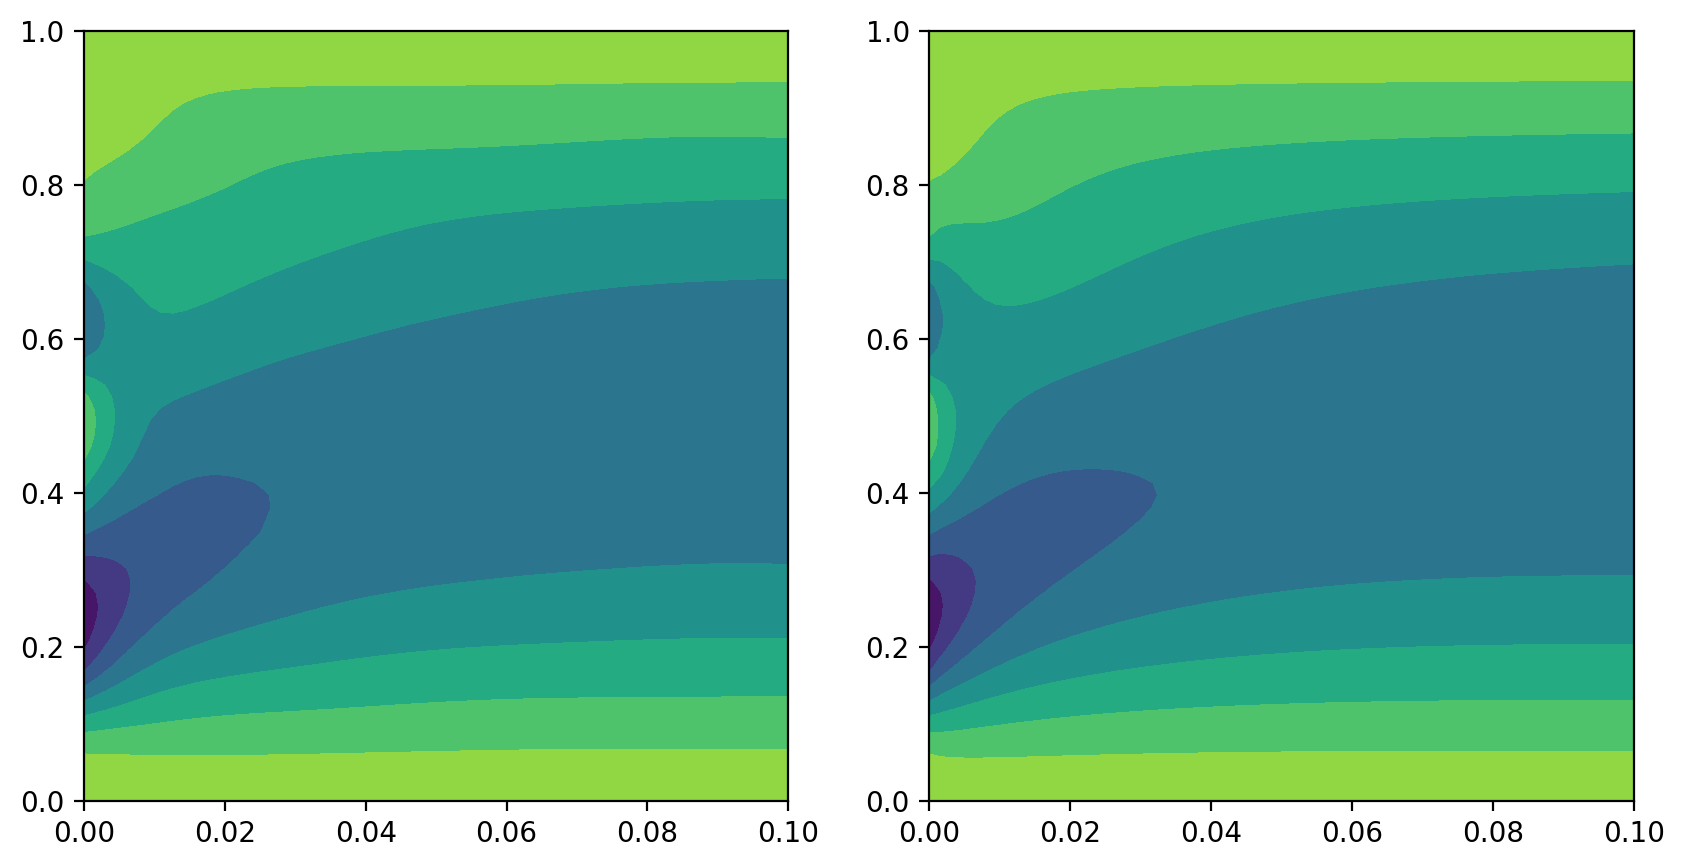

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].contourf(t, x, a_s)
ax[1].contourf(t, x, sol.reshape(N_x, N_t));